# ScanSmart AI

## Introduction

This project focuses on developing, fine-tuning, and interpreting deep learning models for the classification of brain tumor images using MRI scans. The primary goal is to accurately classify MRI images into distinct categories such as glioma, meningioma, notumor, and pituitary, leveraging state-of-the-art transfer learning techniques and hyperparameter tuning.

The workflow begins with the preparation of the dataset, including loading, resizing, and augmenting images. Pre-trained models like VGG16, InceptionV3, and EfficientNetB0 are employed as base models, which are further fine-tuned to improve classification performance on the brain tumor dataset. The project also incorporates advanced techniques such as ensemble modeling to combine the strengths of individual models.

To ensure the robustness and reliability of the models, comprehensive evaluation metrics, including confusion matrices and classification reports, are generated. Additionally, SHAP (SHapley Additive exPlanations) is utilized to interpret the model's predictions, providing insights into how the model makes decisions and enhancing the transparency of the machine learning process.

Overall, this project aims to build a highly accurate and interpretable deep learning solution for brain tumor classification, with potential applications in medical diagnosis and research.


### Importing Necessary Libraries for Image Classification

This code imports a variety of essential libraries and modules needed for building, training, and evaluating an image classification model using TensorFlow and Keras. Below is a breakdown of the imports and their purposes:

- **Basic Libraries**:
  - **`os`**: Used for interacting with the operating system, such as handling file paths.
  - **`PIL.Image`**: The Python Imaging Library (PIL) is used for opening, manipulating, and saving images.
  - **`numpy as np`**: A fundamental package for numerical computations in Python, used here for handling arrays and image data.
  - **`pandas as pd`**: A powerful data manipulation library, though not directly used in this snippet, it might be used for handling datasets.
  - **`matplotlib.pyplot as plt`**: A plotting library used for creating static, animated, and interactive visualizations.
  - **`seaborn as sns`**: Built on top of Matplotlib, Seaborn provides a high-level interface for creating attractive and informative statistical graphics.
  - **`glob`**: Used to retrieve files/pathnames matching a specified pattern.

- **Scikit-learn for Model Evaluation**:
  - **`train_test_split`**: Splits the dataset into training and testing sets.
  - **`classification_report`, `confusion_matrix`**: Tools for evaluating the performance of a classification model.

- **TensorFlow and Keras for Deep Learning**:
  - **`tensorflow as tf`**: TensorFlow is an end-to-end open-source platform for machine learning.
  - **`Sequential`**: A Keras model class used to define a linear stack of layers.
  - **`Dense`, `Dropout`, `Flatten`**: Common Keras layers used to build a neural network. `Dense` layers are fully connected layers, `Dropout` is used for regularization, and `Flatten` reshapes the input.
  - **`Adamax`**: An optimizer from the Adam family, used to minimize the loss function.
  - **`Precision`, `Recall`**: Metrics used to evaluate the performance of the model.
  - **`ImageDataGenerator`**: A Keras utility that allows for real-time data augmentation.
  - **`load_img`, `img_to_array`**: Utilities for loading and converting images to arrays.
  - **`image_dataset_from_directory`**: Used for loading images directly from directories into a format suitable for training a model.
  - **`resize`**: Used to resize images to a consistent shape.

- **Pre-trained Models and Custom Layers**:
  - **`VGG16`, `ResNet50`, `InceptionV3`, `EfficientNetB0`**: Popular pre-trained models from Keras, used for transfer learning in image classification tasks.
  - **`GlobalAveragePooling2D`**: A pooling layer often used after convolutional layers to reduce the spatial dimensions of the feature maps.
  - **`Model`, `load_model`**: Keras functions for creating and loading models.
  
- **Callbacks for Model Training**:
  - **`ModelCheckpoint`**: Saves the model after every epoch if it's performing better.
  - **`EarlyStopping`**: Stops training early if the model stops improving.
  - **`ReduceLROnPlateau`**: Reduces the learning rate when the metric has stopped improving, to allow the model to converge more effectively.

- **Warnings**:
  - **`warnings.filterwarnings("ignore")`**: Suppresses warnings, typically used to clean up the output during model training.

### Summary

This code sets up the necessary environment for building a deep learning image classification model. It imports tools for data preprocessing, model creation, training, evaluation, and more. The combination of TensorFlow, Keras, and various Python libraries allows for efficient handling of large-scale image data and the creation of powerful predictive models.

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import resize
#---------------------------------------
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

2024-08-10 22:36:54.084686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 22:36:54.084801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 22:36:54.216673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Function to Create Training DataFrame

- **`train_df(tr_path)`**: This function generates a pandas DataFrame containing image file paths and their corresponding class labels from a specified directory structure.
  
- **Process**:
  - Iterates through subdirectories (each representing a class) in the given path.
  - Collects file paths and associated class labels.

- **Output**:
  - Returns a DataFrame with two columns: `Class Path` (image file paths) and `Class` (labels).

### Summary

This function simplifies the process of organizing training data by creating a structured DataFrame from a directory of labeled images.

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

### Function to Create Testing DataFrame

- **`test_df(ts_path)`**: This function generates a pandas DataFrame containing image file paths and their corresponding class labels from a specified directory structure for testing data.

- **Process**:
  - Iterates through subdirectories (each representing a class) in the provided test data path.
  - Collects file paths and associated class labels.

- **Output**:
  - Returns a DataFrame with two columns: `Class Path` (image file paths) and `Class` (labels).

### Summary

This function organizes testing data into a structured DataFrame, similar to the training data, facilitating easy processing and evaluation of the model's performance.

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [5]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


### Setting Up Data Paths and Preprocessing for Image Classification

- **Paths Definition**:
  - **`base_dir`**: Base directory containing the dataset.
  - **`train_dir`** and **`test_dir`**: Paths to the training and testing directories, respectively.

- **Image Dimensions**:
  - **`img_height, img_width = 224, 224`**: Specifies the target size for resizing images.

### Data Augmentation and Normalization

- **Training Data Augmentation**:
  - **`train_datagen`**: Includes rescaling, random transformations (rotation, shifts, shear, zoom, flip) to augment the training data, and a validation split.

- **Validation and Testing Data**:
  - **`validation_datagen`** and **`test_datagen`**: Only rescale images without augmentation, used for validation and testing.

### Data Generators

- **Training Data Generator**:
  - **`train_generator`**: Loads and preprocesses training images from the directory with data augmentation.

- **Validation Data Generator**:
  - **`validation_generator`**: Loads and preprocesses validation images (subset of training) without augmentation.

- **Testing Data Generator**:
  - **`test_generator`**: Loads and preprocesses testing images without augmentation.

### Class Indices Verification

- **Class Indices**:
  - **`print(train_generator.class_indices)`** and **`print(test_generator.class_indices)`**: Prints the mapping of class labels to indices to ensure consistency between training and testing datasets.

In [6]:
# Define paths
base_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Image dimensions
img_height, img_width = 224, 224

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [7]:
# Only rescaling for testing
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Load and preprocess the validation data
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load and preprocess the testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Verify the class indices
print(train_generator.class_indices)
print(test_generator.class_indices)

Found 5712 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### Visualizing the Count of Images in Each Class

- **Training Data Class Distribution**:
  - **`plt.figure(figsize=(15,7))`**: Sets the figure size.
  - **`ax = sns.countplot(data=tr_df , y=tr_df['Class'])`**: Creates a horizontal bar plot showing the count of images in each class in the training data.
  - **`plt.title('Count of Training images in each class', fontsize=20)`**: Sets the title for the plot.
  - **`ax.bar_label(ax.containers[0])`**: Adds labels to the bars showing the exact count.

- **Testing Data Class Distribution**:
  - **`plt.figure(figsize=(15, 7))`**: Sets the figure size.
  - **`ax = sns.countplot(y=ts_df['Class'], palette='viridis')`**: Creates a horizontal bar plot showing the count of images in each class in the testing data, with a color palette of 'viridis'.
  - **`ax.set(xlabel='', ylabel='', title='Count of Testing images in each class')`**: Sets the title for the plot.
  - **`ax.bar_label(ax.containers[0])`**: Adds labels to the bars showing the exact count.

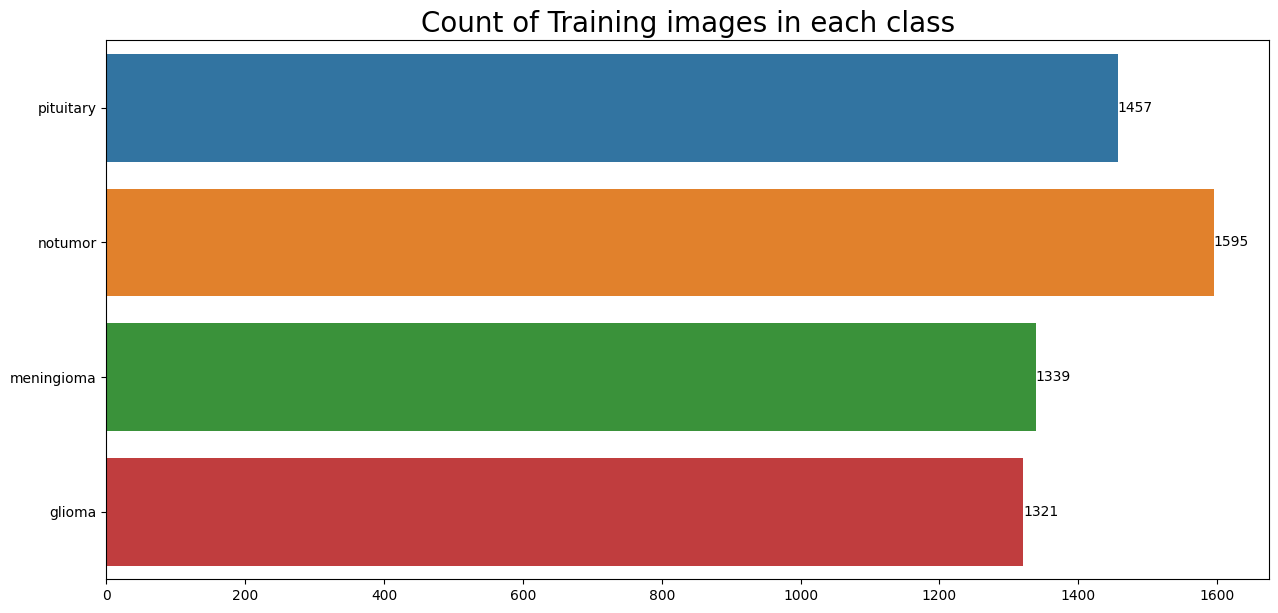

In [9]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of Training images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

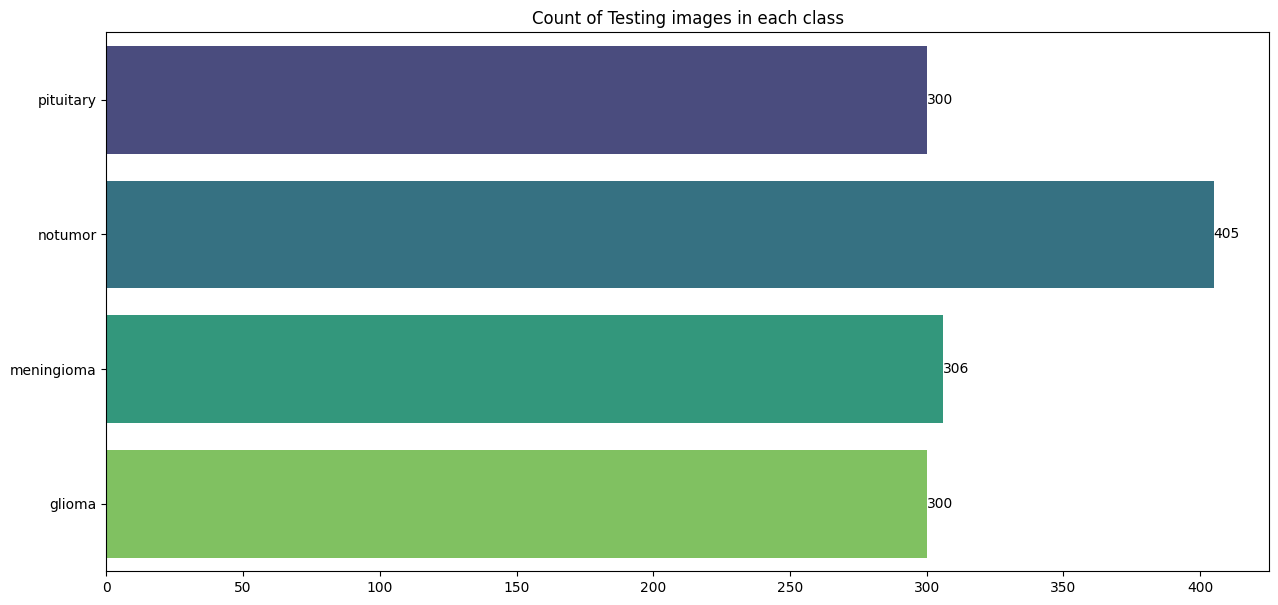

In [10]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of Testing images in each class')
ax.bar_label(ax.containers[0])

plt.show()

### Loading and Resizing Images

- **`load_and_resize_images(directory, target_size)`**: Loads and resizes images from the specified directory, returning image arrays, labels, and class names.

- **Training and Testing Data**:
  - Training: `train_images, train_labels, class_names = load_and_resize_images(train_dir)`
  - Testing: `test_images, test_labels, _ = load_and_resize_images(test_dir)`

- **Dataset Summary**:
  - Number of training images: 5712
  - Number of testing images: 1311
  - Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
# Define paths
base_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Image dimensions
img_height, img_width = 224, 224

# Function to load and resize images
def load_and_resize_images(directory, target_size=(img_height, img_width)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = load_img(img_path)
            image = img_to_array(image)
            image = resize(image, target_size)
            images.append(image.numpy()) 
            labels.append(class_name)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

# Load and resize training data
train_images, train_labels, class_names = load_and_resize_images(train_dir)
test_images, test_labels, _ = load_and_resize_images(test_dir)

# Display basic dataset information
print(f'Number of training images: {len(train_images)}')
print(f'Number of testing images: {len(test_images)}')
print(f'Classes: {class_names}')

Number of training images: 5712
Number of testing images: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Image Dimensions Analysis

- **Function**: 
  - **`analyze_image_dimensions(images)`**: Analyzes the dimensions of the provided image array, counting the occurrences of each unique dimension.

- **Results**:
  - **Training Images**:
    - All 5712 images have dimensions [224, 224, 3].
  - **Testing Images**:
    - All 1311 images have dimensions [224, 224, 3].

### Interpretation:
Both the training and testing images have consistent dimensions of 224x224 pixels with 3 color channels (RGB). This consistency ensures that the images are uniformly processed and ready for input into a convolutional neural network (CNN).

In [12]:
# Analyze image dimensions
def analyze_image_dimensions(images):
    dimensions = [img.shape for img in images]
    dimensions = np.array(dimensions)
    unique_dimensions, counts = np.unique(dimensions, axis=0, return_counts=True)
    for dim, count in zip(unique_dimensions, counts):
        print(f'Dimension: {dim}, Count: {count}')

print('Training Image Dimensions:')
analyze_image_dimensions(train_images)
print('Testing Image Dimensions:')
analyze_image_dimensions(test_images)

Training Image Dimensions:
Dimension: [224 224   3], Count: 5712
Testing Image Dimensions:
Dimension: [224 224   3], Count: 1311


In [13]:
# Compute basic statistics
def compute_statistics(images):
    pixel_values = images.ravel()
    mean = np.mean(pixel_values)
    std = np.std(pixel_values)
    min_val = np.min(pixel_values)
    max_val = np.max(pixel_values)
    return mean, std, min_val, max_val

train_mean, train_std, train_min, train_max = compute_statistics(train_images)
test_mean, test_std, test_min, test_max = compute_statistics(test_images)

print(f'Training Data - Mean: {train_mean}, Std: {train_std}, Min: {train_min}, Max: {train_max}')
print(f'Testing Data - Mean: {test_mean}, Std: {test_std}, Min: {test_min}, Max: {test_max}')

Training Data - Mean: 47.285579681396484, Std: 51.528846740722656, Min: 0.0, Max: 255.0
Testing Data - Mean: 49.151268005371094, Std: 53.712154388427734, Min: 0.0, Max: 255.0


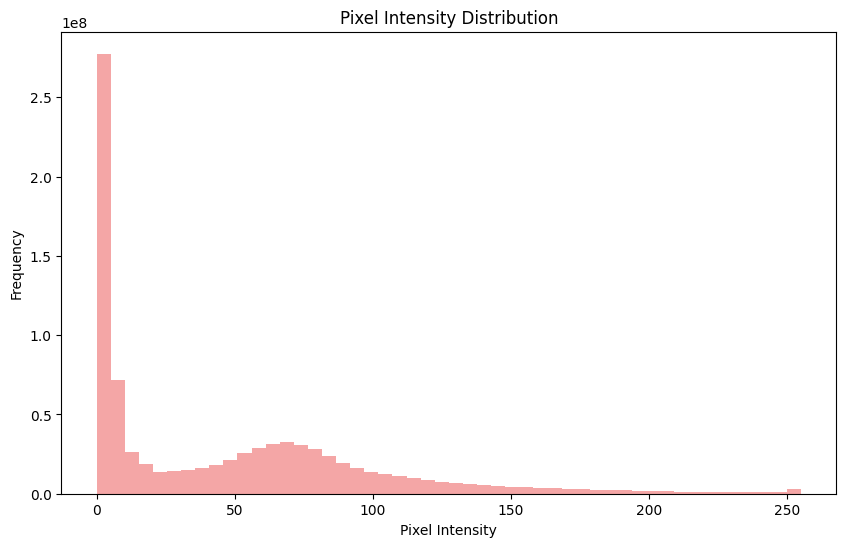

In [14]:
def plot_pixel_intensity_distribution(images):
    flattened_images = images.reshape(-1, images.shape[-1])
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_images.flatten(), bins=50, color='lightcoral', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_intensity_distribution(train_images)

### Data Preprocessing and Generators Setup

- **Loading and Preprocessing Data**:
  - Training and testing images are loaded from directories, resized to `224x224`, and normalized (divided by 255).
  - Labels are mapped to numerical values using `label_map`.

- **Splitting Data**:
  - The training data is split into training (80%) and validation (20%) sets using `train_test_split` with stratification.

- **Data Generators**:
  - **`train_datagen`**: Applies data augmentation (rotation, shift, shear, zoom, flip) to the training images.
  - **`test_datagen`**: Used for validation and testing images, without augmentation.

- **Flow Generators**:
  - **`train_generator`**: Feeds augmented training images in batches.
  - **`val_generator`**: Feeds validation images in batches.
  - **`test_generator`**: Feeds testing images in batches (no shuffle).


In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import tempfile
import shutil

# Load and preprocess training data
train_images = []
train_labels = []
class_names = sorted(os.listdir(train_dir))
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        train_images.append(image)
        train_labels.append(label_map[class_name])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load and preprocess testing data
test_images = []
test_labels = []

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        test_images.append(image)
        test_labels.append(label_map[class_name])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = test_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

### Model Creation with Transfer Learning and Hyperparameter Tuning

- **`build_model(hp, base_model)`**:
  - Constructs a model using a pre-trained base model with hyperparameter tuning for the dense layer units, dropout rate, and learning rate.
  - Utilizes `GlobalAveragePooling2D`, a tunable `Dense` layer, and a `Dropout` layer.
  - Compiles the model with a tunable learning rate using the Adam optimizer.

- **Pre-trained Models**:
  - Uses **VGG16**, **InceptionV3**, and **EfficientNetB0** as base models, excluding the top layers and loading `imagenet` weights.

- **Hyperparameter Tuning**:
  - For each pre-trained model:
    - Freezes the base model layers.
    - Defines a hypermodel function for Keras Tuner.
    - Uses `RandomSearch` from Keras Tuner to search for the best hyperparameters based on validation accuracy.
    - Fine-tunes the model by unfreezing the top layers and retraining with a reduced learning rate.
  
- **Training and Evaluation**:
  - Performs training with early stopping and learning rate reduction callbacks.
  - Evaluates the fine-tuned model on the test dataset and stores the best model.

- **Temporary Directory**:
  - Utilizes a temporary directory for storing Keras Tuner outputs, which is cleaned up after tuning.


In [16]:
# Create a function to create a model with transfer learning and hyperparameter tuning
def build_model(hp, base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units', min_value=512, max_value=2048, step=512), activation='relu')(x)
    x = Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1))(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# List of pre-trained models to use
pretrained_models = {
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
}

fine_tuned_models = {}

# Use a temporary directory for Keras Tuner
temp_dir = tempfile.mkdtemp()

try:
    for model_name, base_model in pretrained_models.items():
        print(f"Tuning model: {model_name}")

        # Freeze the layers of the base model
        for layer in base_model.layers:
            layer.trainable = False

        # Hypermodel function for Keras Tuner
        def hypermodel(hp):
            return build_model(hp, base_model)

        tuner = kt.RandomSearch(
            hypermodel,
            objective='val_accuracy',
            max_trials=3,
            executions_per_trial=2,
            directory=temp_dir,  # Use temporary directory
            project_name=f'{model_name}_tuning'
        )

        tuner.search_space_summary()

        # Perform hyperparameter search
        tuner.search(train_generator,
                     epochs=5,
                     validation_data=val_generator,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

        # Get the optimal hyperparameters and best model
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model = tuner.hypermodel.build(best_hp)

        # Unfreeze some of the top layers for fine-tuning
        for layer in best_model.layers[-4:]:
            layer.trainable = True

        # Compile the model with a lower learning rate
        best_model.compile(optimizer=Adam(learning_rate=best_hp.get('learning_rate')), 
                           loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model with fine-tuning
        best_model.fit(
            train_generator,
            epochs=5,
            validation_data=val_generator,
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
            ]
        )

        # Evaluate the model on the test set
        test_loss, test_acc = best_model.evaluate(test_generator)
        print(f"Fine-tuned {model_name} Test Accuracy: {test_acc:.4f}")

        fine_tuned_models[model_name] = best_model
finally:
    # Clean up temporary directory
    shutil.rmtree(temp_dir)

Trial 3 Complete [00h 10m 15s]
val_accuracy: 0.27909010648727417

Best val_accuracy So Far: 0.27909010648727417
Total elapsed time: 00h 31m 55s
Epoch 1/5
  2/143 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.2578 - loss: 2.3282    

W0000 00:00:1723335300.896353      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 59/143 ━━━━━━━━━━━━━━━━━━━━ 49s 589ms/step - accuracy: 0.2465 - loss: 1.9122

W0000 00:00:1723335334.939866      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.2558 - loss: 1.6833

W0000 00:00:1723335363.953987      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723335368.184269      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 475ms/step - accuracy: 0.2559 - loss: 1.6804 - val_accuracy: 0.2310 - val_loss: 1.3886 - learning_rate: 0.0100
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 301ms/step - accuracy: 0.2569 - loss: 1.3892 - val_accuracy: 0.2791 - val_loss: 1.3835 - learning_rate: 0.0100
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 298ms/step - accuracy: 0.2861 - loss: 1.3837 - val_accuracy: 0.2791 - val_loss: 1.3837 - learning_rate: 0.0100
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 299ms/step - accuracy: 0.2724 - loss: 1.3865 - val_accuracy: 0.2791 - val_loss: 1.3850 - learning_rate: 0.0100
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 299ms/step - accuracy: 0.2791 - loss: 1.3854 - val_accuracy: 0.2791 - val_loss: 1.3838 - learning_rate: 0.0100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.1600 - loss: 1.4301
Fine-tuned EfficientNetB0 Test Accuracy: 0.3089


W0000 00:00:1723335559.393801      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Saving Fine-Tuned Models

- **Save Models**:
  - Serializes the `fine_tuned_models` dictionary, which contains the fine-tuned models, to a pickle file named `'fine_tuned_models.pkl'`.
  - Uses `pickle.dump` to write the dictionary to the file.


- **Confirmation**:
  - Prints a confirmation message indicating that the models have been successfully saved.

In [17]:
import pickle

# Save the fine-tuned models dictionary to a pickle file
with open('fine_tuned_models.pkl', 'wb') as f:
    pickle.dump(fine_tuned_models, f)

print("Fine-tuned models saved as 'fine_tuned_models.pkl'")

Fine-tuned models saved as 'fine_tuned_models.pkl'


### Evaluating Fine-Tuned Models

- **True Labels**:
  - `true_classes`: Contains the true labels for the test data.

- **Class Labels**:
  - `class_labels`: Contains the names of the classes.

- **Model Evaluation**:
  - For each fine-tuned model in `fine_tuned_models`:
    - **Predictions**: Uses the model to predict the classes for the test data.
    - **Confusion Matrix**: Computes and prints the confusion matrix for the predicted vs. true labels.
    - **Classification Report**: Generates and prints a detailed classification report including precision, recall, and F1-score for each class.
    - **Test Accuracy**: Evaluates and prints the test accuracy of the model.


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Track true labels separately
true_classes = test_labels

# Get the names of the classes
class_labels = class_names

# Evaluate each fine-tuned model individually and print the classification report
for model_name, model in fine_tuned_models.items():
    # Use the model to predict the labels for the test data
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    print(f"{model_name} Confusion Matrix:")
    print(cm)

    # Generate and print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f"{model_name} Classification Report:")
    print(report)

    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

 2/41 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step 

W0000 00:00:1723335564.547176      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
VGG16 Confusion Matrix:
[[212  61   2  25]
 [ 24 172  25  85]
 [ 11  12 375   7]
 [  2   1   0 297]]
VGG16 Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.71      0.77       300
  meningioma       0.70      0.56      0.62       306
     notumor       0.93      0.93      0.93       405
   pituitary       0.72      0.99      0.83       300

    accuracy                           0.81      1311
   macro avg       0.80      0.80      0.79      1311
weighted avg       0.81      0.81      0.80      1311

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.7071 - loss: 0.7644
VGG16 Test Accuracy: 0.8055
 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step

W0000 00:00:1723335583.693475      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step
InceptionV3 Confusion Matrix:
[[273  22   1   4]
 [ 64 194  21  27]
 [ 12  11 373   9]
 [  7   8   1 284]]
InceptionV3 Classification Report:
              precision    recall  f1-score   support

      glioma       0.77      0.91      0.83       300
  meningioma       0.83      0.63      0.72       306
     notumor       0.94      0.92      0.93       405
   pituitary       0.88      0.95      0.91       300

    accuracy                           0.86      1311
   macro avg       0.85      0.85      0.85      1311
weighted avg       0.86      0.86      0.85      1311

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8383 - loss: 0.4025
InceptionV3 Test Accuracy: 0.8574
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

W0000 00:00:1723335603.508623      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step


W0000 00:00:1723335610.115500      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


EfficientNetB0 Confusion Matrix:
[[  0   0 300   0]
 [  0   0 306   0]
 [  0   0 405   0]
 [  0   0 300   0]]
EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1600 - loss: 1.4301
EfficientNetB0 Test Accuracy: 0.3089


### Model Evaluation with Confusion Matrix and Classification Report

- **Function**: 
  - **`plot_confusion_matrix(cm, class_names, model_name)`**: Plots a confusion matrix as a heatmap, annotating the counts of true vs. predicted classes.

- **Model Evaluation Loop**:
  - **Predictions**: Each model in `fine_tuned_models` is used to predict classes on the test set.
  - **Confusion Matrix**: Computes and prints the confusion matrix for each model, followed by a plot of the matrix.
  - **Classification Report**: Generates and prints a classification report, detailing precision, recall, and F1-score.
  - **Test Accuracy**: Evaluates and prints the accuracy of each model on the test data.
  - **Error Handling**: Catches and prints any exceptions that occur during evaluation to ensure the loop continues even if one model fails.

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate each fine-tuned model individually and print the classification report and plot confusion matrix
for model_name, model in fine_tuned_models.items():
    print(f"Evaluating model: {model_name}")
    
    try:
        # Use the model to predict the labels for the test data
        predictions = model.predict(test_generator)
        predicted_classes = np.argmax(predictions, axis=1)

        # Get the true labels
        true_classes = test_generator.classes

        # Get the names of the classes
        class_labels = list(test_generator.class_indices.keys())

        # Calculate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print(f"{model_name} Confusion Matrix:")
        print(cm)

        # Plot confusion matrix
        plot_confusion_matrix(cm, class_labels, model_name)

        # Generate and print classification report
        report = classification_report(true_classes, predicted_classes, target_names=class_labels)
        print(f"{model_name} Classification Report:")
        print(report)

        # Evaluate the model on the test data
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    
    except Exception as e:
        print(f"An error occurred while evaluating {model_name}: {e}")

Evaluating model: VGG16
 2/41 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step 

W0000 00:00:1723335614.722171      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step
An error occurred while evaluating VGG16: 'NumpyArrayIterator' object has no attribute 'classes'
Evaluating model: InceptionV3
 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

W0000 00:00:1723335625.352999      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step
An error occurred while evaluating InceptionV3: 'NumpyArrayIterator' object has no attribute 'classes'
Evaluating model: EfficientNetB0
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

W0000 00:00:1723335639.981878      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step
An error occurred while evaluating EfficientNetB0: 'NumpyArrayIterator' object has no attribute 'classes'


W0000 00:00:1723335646.789105      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Ensemble Model Evaluation

- **Confusion Matrix Plotting Function**:
  - **`plot_confusion_matrix(cm, class_names, model_name)`**: Plots a confusion matrix for the given model using Seaborn's heatmap.

- **Loading Models**:
  - **`loaded_models = pickle.load(f)`**: Loads the fine-tuned models from the `fine_tuned_models.pkl` file.

- **Ensemble Predictions**:
  - **`create_ensemble(models, test_generator)`**: Generates ensemble predictions by averaging the predictions of all loaded models.

- **Ensemble Accuracy**:
  - Calculates and prints the ensemble's test accuracy by comparing the averaged predictions with the true test labels.

- **Confusion Matrix and Classification Report**:
  - **Ensemble Confusion Matrix**: Computes and prints the confusion matrix for the ensemble predictions.
  - **Ensemble Classification Report**: Generates and prints a classification report for the ensemble.

- **Visualization**:
  - **`plot_confusion_matrix(ensemble_cm, class_names, "Ensemble Model")`**: Visualizes the confusion matrix for the ensemble model.

 2/41 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step 

W0000 00:00:1723335662.178177      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step
 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

W0000 00:00:1723335672.284517      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

W0000 00:00:1723335684.503970      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step


W0000 00:00:1723335690.503050      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Ensemble Test Accuracy: 0.8520
Ensemble Confusion Matrix:
[[254  38   2   6]
 [ 42 187  24  53]
 [ 10   7 384   4]
 [  6   1   1 292]]
Ensemble Classification Report:
              precision    recall  f1-score   support

      glioma       0.81      0.85      0.83       300
  meningioma       0.80      0.61      0.69       306
     notumor       0.93      0.95      0.94       405
   pituitary       0.82      0.97      0.89       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



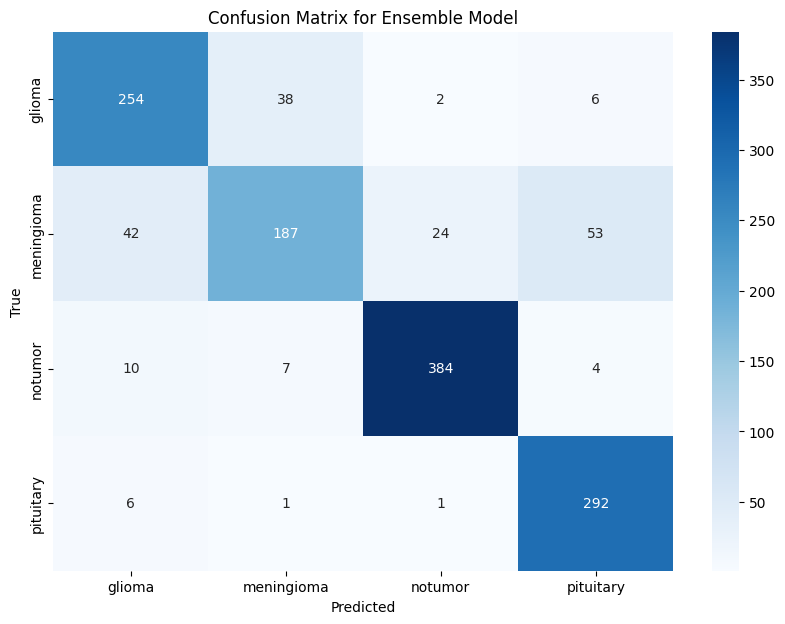

In [20]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Load the fine-tuned models from the pickle file
with open('fine_tuned_models.pkl', 'rb') as f:
    loaded_models = pickle.load(f)

# Function to create ensemble predictions
def create_ensemble(models, test_generator):
    preds = [model.predict(test_generator) for model in models]
    avg_preds = np.mean(preds, axis=0)
    return avg_preds

# Generate ensemble predictions
ensemble_preds = create_ensemble(loaded_models.values(), test_generator)

# Calculate ensemble accuracy
ensemble_accuracy = np.mean(np.argmax(ensemble_preds, axis=1) == test_labels)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

# Generate confusion matrix and classification report for the ensemble
ensemble_predicted_classes = np.argmax(ensemble_preds, axis=1)
ensemble_cm = confusion_matrix(test_labels, ensemble_predicted_classes)
ensemble_report = classification_report(test_labels, ensemble_predicted_classes, target_names=class_names)

print("Ensemble Confusion Matrix:")
print(ensemble_cm)
print("Ensemble Classification Report:")
print(ensemble_report)

# Visualize the confusion matrix
plot_confusion_matrix(ensemble_cm, class_names, "Ensemble Model")

### SHAP Model Explanation for Image Classification

- **Sample Image Preparation**:
  - **`sample_image = test_images[0:1]`**: Selects a single image from the test set.
  - Ensures the sample image has the correct shape for model input (batch size, height, width, channels).

- **SHAP Explanation Function**:
  - **`explain_model(model, sample_image, train_images)`**:
    - Attempts to explain the model's predictions using SHAP.
    - **DeepExplainer**:
      - Tries using SHAP's `DeepExplainer` for deep learning models, using the model's input and output layers.
      - If successful, calculates SHAP values for the sample image.
    - **KernelExplainer**:
      - If `DeepExplainer` fails, attempts to use `KernelExplainer`.
      - Flattens the sample image and training images for compatibility with `KernelExplainer`.
      - Defines a wrapper function for model predictions on flattened data.
    - **Visualization**:
      - If SHAP values are successfully generated, visualizes the explanations using `shap.image_plot`.
    - If both explainers fail, outputs an error message.

- **Execution**:
  - The function is called to generate and visualize SHAP explanations for the selected sample image using the model.

In [21]:
import shap
import numpy as np

# Load a single image from the test set and ensure it's in the correct format
sample_image = test_images[0:1]

# Ensure sample image has the correct shape (batch size, height, width, channels)
if len(sample_image.shape) == 3:
    sample_image = np.expand_dims(sample_image, axis=0)

# Function to explain the model's predictions using SHAP
def explain_model(model, sample_image, train_images):
    shap_values = None

    # Attempt to use DeepExplainer (useful for deep learning models, but can be tricky with TF models)
    try:
        print("Trying SHAP DeepExplainer...")
        explainer = shap.DeepExplainer((model.input, model.layers[-1].output), train_images[:100])
        shap_values = explainer.shap_values(sample_image)
        print("SHAP DeepExplainer successful!")
    except Exception as e:
        print(f"SHAP DeepExplainer failed: {e}")

    # If DeepExplainer fails, try KernelExplainer
    if shap_values is None:
        try:
            print("Trying SHAP KernelExplainer...")
            # Flatten the image and adjust for KernelExplainer input
            sample_image_flat = sample_image.reshape((sample_image.shape[0], -1))
            train_images_flat = train_images[:100].reshape((100, -1))

            # Define a wrapper function for model prediction
            def model_predict_flat(input_data):
                input_data = input_data.reshape((-1, *sample_image.shape[1:]))
                return model.predict(input_data)

            explainer = shap.KernelExplainer(model_predict_flat, train_images_flat)
            shap_values = explainer.shap_values(sample_image_flat)
            print("SHAP KernelExplainer successful!")
        except Exception as e:
            print(f"SHAP KernelExplainer failed: {e}")

    # If SHAP explanations were successful, visualize them
    if shap_values is not None:
        shap.image_plot([shap_values], sample_image)
    else:
        print("Failed to generate SHAP explanations with both DeepExplainer and KernelExplainer.")

# Call the function to explain the model
explain_model(model, sample_image, train_images)

Trying SHAP DeepExplainer...
SHAP DeepExplainer failed: 'tuple' object has no attribute 'as_list'
Trying SHAP KernelExplainer...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


W0000 00:00:1723335704.100293      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
